**11조 - 최승선 이성민 최형찬 이영준**

# **1. 데이터 소개**

**1. 주제**    
스마트팜 시계열 센서 데이터를 활용한 농작물 성장률 예측   

**2. 2020 / 2021 일별 환경 데이터**     
- 수집일    
- 내부 CO2(ppm)   
- 내부 습도(%)    
- 일사량(W/m-2·s)    
- 외부 온도(도)    
- 내부 온도(도)    
- 외부 풍속(m/s)    
- 적산온도(도)
- **적산온도증가량(추가 컬럼)**  &rarr; target


# **2. 필요한 라이브러리 로드**

In [14]:
# 1. 데이터 처리·기초 연산
import pandas as pd
import numpy as np
from pandas import Timestamp

# 2. 시각화 (EDA 및 결과 해석)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 등 시각화 환경 조정이 필요하면 아래에 추가
plt.rcParams['font.family'] = 'Malgun Gothic'

# **3. 데이터 로드 및 확인**

In [19]:
e20 = pd.read_excel('2020_feature.xlsx',parse_dates=["수집일"])
e21 = pd.read_excel('2021_feature.xlsx',parse_dates=["수집일"])

In [21]:
e20.head()

,수집일,내부CO2(ppm),내부습도(%),일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s),적산온도(도)
0,2020-12-31,224.00,60.00,0.00,-9.00,7.00,0.00,7.00
1,2021-01-01,NaN,61.00,0.00,-5.00,NaN,0.00,NaN
2,2021-01-02,245.38,58.63,114.46,-3.53,9.00,0.38,16.00
3,2021-01-03,230.17,59.21,76.75,-3.84,8.67,0.10,24.67
4,2021-01-04,235.06,61.18,92.00,-3.78,9.86,0.31,34.53


In [23]:
e21.head()

,수집일,내부CO2(ppm),내부습도(%),일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s),적산온도(도)
0,2021-10-24,298.46,34.21,175.26,10.61,12.25,0.09,12.25
1,2021-10-25,301.46,34.50,142.30,9.87,12.13,0.09,24.38
2,2021-10-26,321.58,36.75,145.83,10.75,12.17,0.04,36.55
3,2021-10-27,306.67,36.92,118.00,11.91,12.21,0.14,48.76
4,2021-10-28,323.54,33.79,155.86,9.86,12.42,0.09,61.18


# **4. 데이터 전처리**

### **4-1. 환경 데이터 결측치 확인**

In [27]:
e20.isna().sum()

수집일             0
내부CO2(ppm)      1
내부습도(%)         1
일사량(W/m-2·s)    0
외부온도(도)         0
내부온도(도)         1
외부풍속(m/s)       0
적산온도(도)         1
dtype: int64

In [29]:
e21.isna().sum()

수집일             0
내부CO2(ppm)      0
내부습도(%)         0
일사량(W/m-2·s)    0
외부온도(도)         0
내부온도(도)         0
외부풍속(m/s)       0
적산온도(도)         0
dtype: int64

In [31]:
nan_idx = e20[e20["내부습도(%)"].isna()].index[0]

# ±2 인덱스 추출
start = max(nan_idx - 2, 0)
end = nan_idx + 3
e20.iloc[start:end]

,수집일,내부CO2(ppm),내부습도(%),일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s),적산온도(도)
126,2021-05-06,318.17,54.42,224.95,13.82,12.92,0.29,1373.65
127,2021-05-07,358.93,59.64,84.67,13.23,12.73,1.73,1386.38
128,2021-05-09,276.00,NaN,456.50,16.00,18.25,0.50,1404.63
129,2021-05-10,314.04,61.00,49.29,11.95,10.96,0.88,1415.59
130,2021-05-11,310.29,60.88,98.21,15.48,11.96,1.19,1427.55


### **2021년 5월 8일에 대한 정보가 없는 것을 확인**

In [34]:
# 결측치 확인 후 앞뒤 값 평균으로 채우기

num_cols = ['내부CO2(ppm)', '내부습도(%)', '일사량(W/m-2·s)', 
            '외부온도(도)', '내부온도(도)', '외부풍속(m/s)', '적산온도(도)']

for col in num_cols:
    nan_idx = e20[e20[col].isna()].index
    for idx in nan_idx:
        prev_val = e20.at[idx - 1, col]
        next_val = e20.at[idx + 1, col]
        e20.at[idx, col] = (prev_val + next_val) / 2

In [36]:
# 5월 7일, 5월 9일 기준 열 (수집일 제외한 수치형 열 자동 처리)
cols_to_average = e20.columns.drop("수집일")

# 5월 7일과 9일의 값 추출
row_7 = e20.loc[e20["수집일"] == Timestamp("2021-05-07"), cols_to_average]
row_9 = e20.loc[e20["수집일"] == Timestamp("2021-05-09"), cols_to_average]

# 평균 계산
row_avg = ((row_7.values + row_9.values) / 2).flatten()

# 새 row 생성
new_row = pd.DataFrame([row_avg], columns=cols_to_average)
new_row.insert(0, "수집일", Timestamp("2021-05-08"))

# 기존 데이터에 삽입 후 정렬
e20 = pd.concat([e20, new_row], ignore_index=True).sort_values(by="수집일").reset_index(drop=True)

# 적산온도를 적산온도 변화량으로 교체
e20['적산온도_증가량(도)'] = e20['적산온도(도)'].diff().fillna(0)
e21['적산온도_증가량(도)'] = e21['적산온도(도)'].diff().fillna(0)

In [38]:
e20

,수집일,내부CO2(ppm),내부습도(%),일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s),적산온도(도),적산온도_증가량(도)
0,2020-12-31,224.00,60.00,0.00,-9.00,7.00,0.00,7.00,0.00
1,2021-01-01,234.69,61.00,0.00,-5.00,8.00,0.00,11.50,4.50
2,2021-01-02,245.38,58.63,114.46,-3.53,9.00,0.38,16.00,4.50
3,2021-01-03,230.17,59.21,76.75,-3.84,8.67,0.10,24.67,8.67
4,2021-01-04,235.06,61.18,92.00,-3.78,9.86,0.31,34.53,9.86
...,...,...,...,...,...,...,...,...,...
132,2021-05-12,301.58,51.96,352.05,21.19,15.67,1.00,1443.22,15.67
133,2021-05-13,325.42,45.25,280.23,20.35,16.46,0.58,1459.68,16.46
134,2021-05-14,327.75,46.79,242.68,22.00,16.96,0.50,1476.64,16.96
135,2021-05-15,335.00,55.92,115.33,21.68,16.25,0.36,1492.89,16.25


In [40]:
e21

,수집일,내부CO2(ppm),내부습도(%),일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s),적산온도(도),적산온도_증가량(도)
0,2021-10-24,298.46,34.21,175.26,10.61,12.25,0.09,12.25,0.00
1,2021-10-25,301.46,34.50,142.30,9.87,12.13,0.09,24.38,12.13
2,2021-10-26,321.58,36.75,145.83,10.75,12.17,0.04,36.55,12.17
3,2021-10-27,306.67,36.92,118.00,11.91,12.21,0.14,48.76,12.21
4,2021-10-28,323.54,33.79,155.86,9.86,12.42,0.09,61.18,12.42
...,...,...,...,...,...,...,...,...,...
214,2022-05-26,410.04,53.42,323.38,18.17,14.88,0.58,2445.98,14.88
215,2022-05-27,403.25,54.08,320.67,19.13,15.29,1.21,2461.27,15.29
216,2022-05-28,418.04,58.46,271.63,20.75,15.54,0.83,2476.81,15.54
217,2022-05-29,413.75,65.63,304.33,21.38,15.67,0.25,2492.48,15.67


In [48]:
print(e20.isna().sum() ,'\n')
print(e21.isna().sum())

수집일             0
내부CO2(ppm)      0
내부습도(%)         0
일사량(W/m-2·s)    0
외부온도(도)         0
내부온도(도)         0
외부풍속(m/s)       0
적산온도(도)         0
적산온도_증가량(도)     0
dtype: int64 

수집일             0
내부CO2(ppm)      0
내부습도(%)         0
일사량(W/m-2·s)    0
외부온도(도)         0
내부온도(도)         0
외부풍속(m/s)       0
적산온도(도)         0
적산온도_증가량(도)     0
dtype: int64


In [191]:
e20['수집일'] = pd.to_datetime(e20['수집일'])
e20.set_index('수집일', inplace=True)

In [192]:
e21['수집일'] = pd.to_datetime(e21['수집일'])
e21.set_index('수집일', inplace=True)

# **적산온도란?**

**적산온도:** 생물이 자라기 위해 필요한 열의 양을 시간에 따라 모은 것

**적산온도 증가량을 타겟으로 사용하려는 이유:**  

- 누적된 온도를 얻어야 꽃이 피고, 착과(열매 맺기)가 진행됨

> **ex)**   
> - 적산온도 **300~500**: 개화 시작  
> - 적산온도 **800~1200**: 착과(과실맺기)  
> - 적산온도 **1800~2200**: 수확 준비  
> - 적산온도 **2500 이상**: 과숙 (과일이 너무 익어 상품성 저하)

---

# **방울 토마토 기준 적산온도의 해석**

- **8℃ 이하**:  
  ➔ 내부 온도·일사량 부족 ➔ 성장 정체 가능성  

- **15℃ 이상**:  
  ➔ 내부 온도 과도 상승 ➔ 비대 성장하거나 병충해 위험 증가  

- **20℃ 이상**:  
  ➔ 내부 과열 ➔ 열스트레스, 품질 저하 가능성

  **적산온도의 증가량으로 이러한 정보를 얻을수 있고 일 단위의 데이터도 확보 가능하여 화방높이보다 더 유리하다고 판단하였습니다.**

### **5. 컬럼 영문화**

In [193]:
col_map_e = {
    '내부CO2(ppm)':     'co2_ppm',                    # 내부 CO₂ 농도
    '내부습도(%)':       'inside_rh_pct',             # 내부 상대습도
    '일사량(W/m-2·s)':  'irradiance_w_m2_s',          # 일사량
    '외부온도(도)':      'outside_temp_c',             # 외부 기온
    '내부온도(도)':      'inside_temp_c',              # 내부 기온
    '외부풍속(m/s)':     'outside_wind_ms',            # 외부 풍속
    '적산온도(도)':      'cumulative_temp_c',          # 적산 온도
    '적산온도_증가량(도)': 'cumulative_temp_increase_c' #적산 온도 증가량
}

e20 = e20.rename(columns=col_map_e)
e21 = e21.rename(columns=col_map_e)

In [194]:
e20.head()
e20.shape

(137, 8)

In [195]:
e21.head()
e21.shape

(219, 8)

### **6. EDA**

In [196]:
# 1. 데이터 기본 정보 확인
print("데이터 크기:", e20.shape)
print("\n데이터 정보:")
e20.info()
# 2. 기본 통계량
print("\n 기본 통계량 (describe):")
print(e20.describe())

데이터 크기: (137, 8)

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 2020-12-31 to 2021-05-16
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   co2_ppm                     137 non-null    float64
 1   inside_rh_pct               137 non-null    float64
 2   irradiance_w_m2_s           137 non-null    float64
 3   outside_temp_c              137 non-null    float64
 4   inside_temp_c               137 non-null    float64
 5   outside_wind_ms             137 non-null    float64
 6   cumulative_temp_c           137 non-null    float64
 7   cumulative_temp_increase_c  137 non-null    float64
dtypes: float64(8)
memory usage: 9.6 KB

 기본 통계량 (describe):
          co2_ppm  inside_rh_pct  irradiance_w_m2_s  outside_temp_c  \
count  137.000000     137.000000         137.000000      137.000000   
mean   318.218358      54.715109         150.175730        6.935000   
std    

In [197]:
print(e20.index)

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10',
               '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14',
               '2021-05-15', '2021-05-16'],
              dtype='datetime64[ns]', name='수집일', length=137, freq=None)


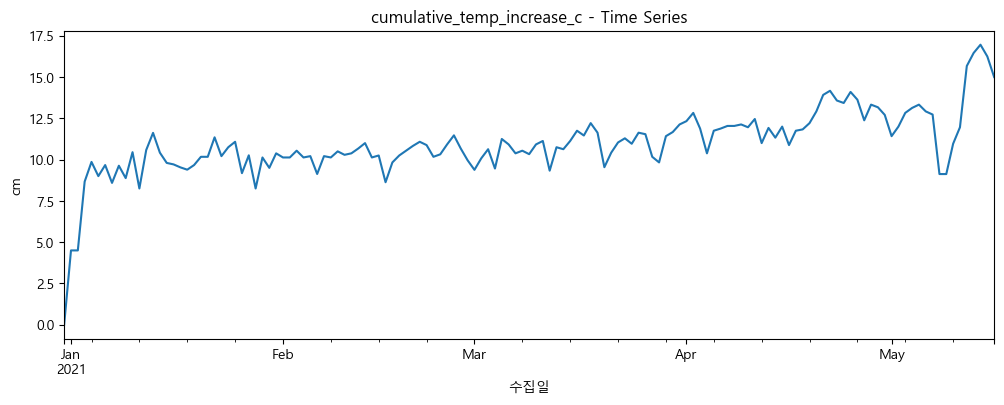

In [198]:
# 적산온도증가량 변동
fig, ax = plt.subplots(figsize=(12,4))
e20['cumulative_temp_increase_c'].plot(ax=ax)
ax.set(title='cumulative_temp_increase_c - Time Series', ylabel='cm')
plt.show()

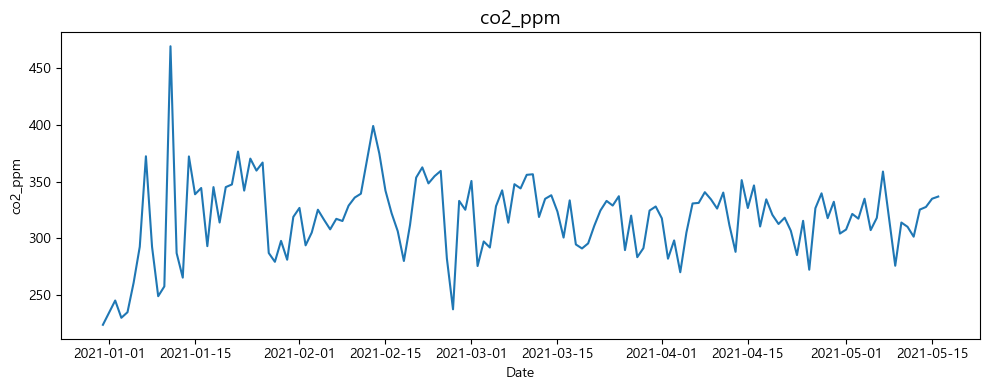

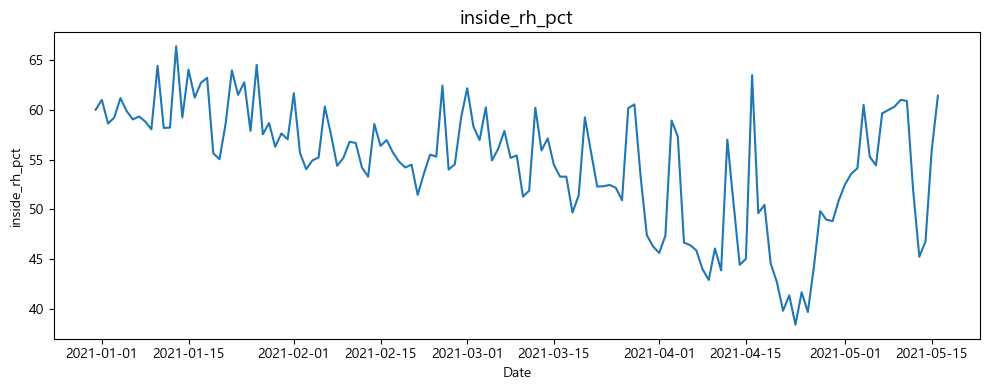

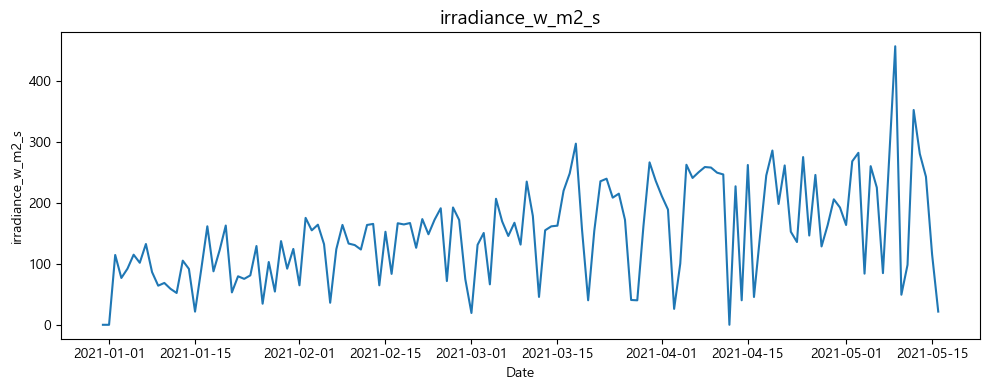

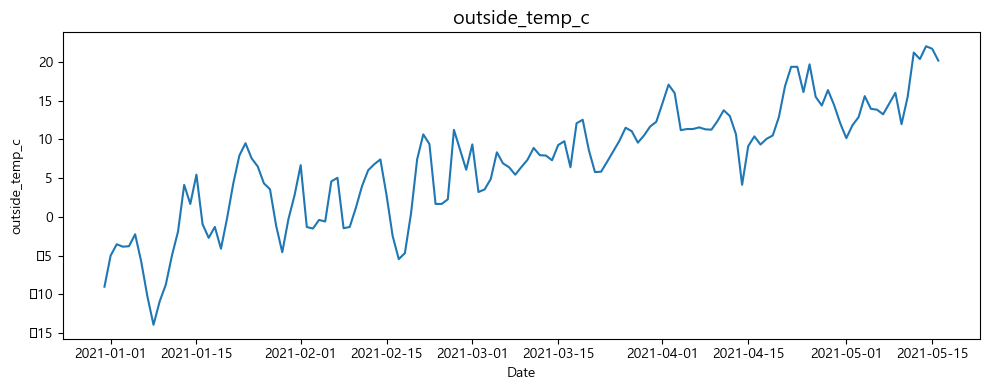

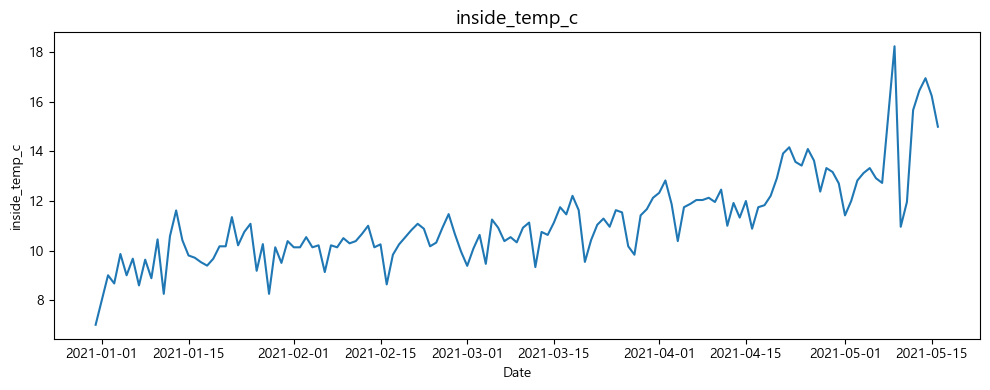

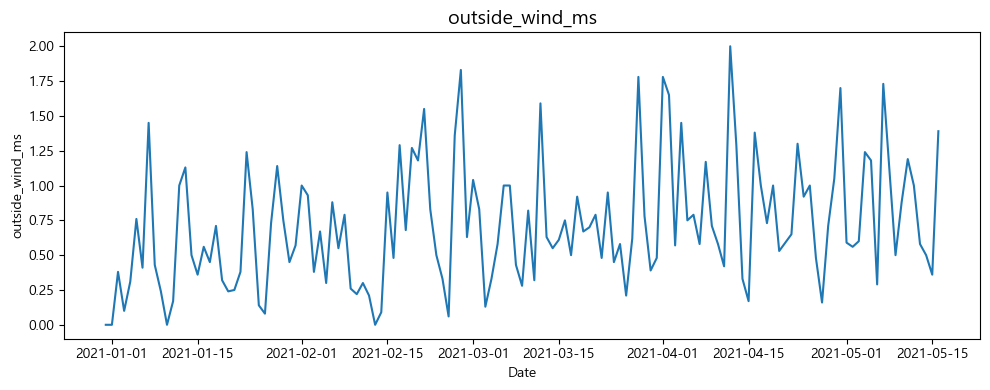

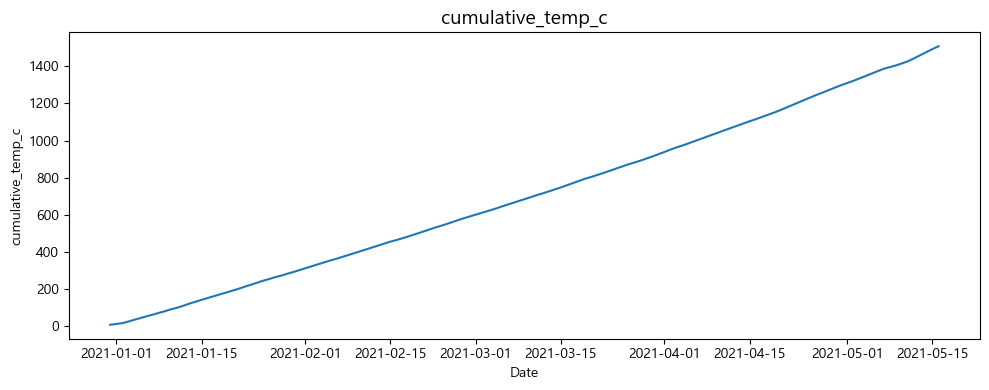

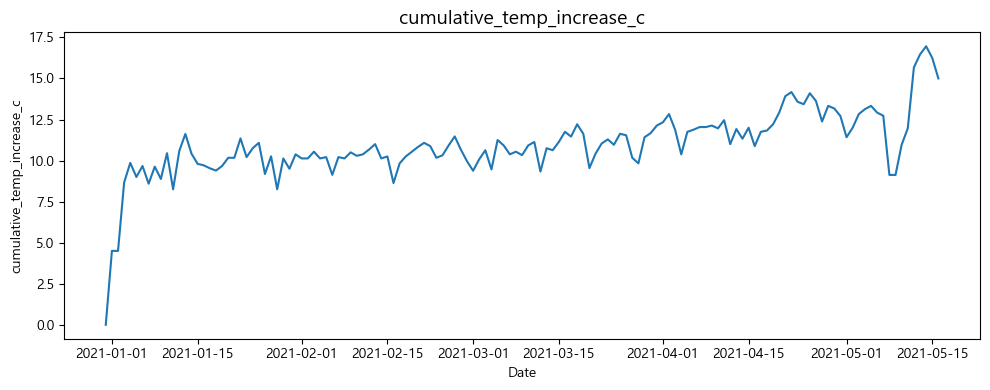

In [199]:
# ② 모든 컬럼(또는 sensor_cols 등 원하는 리스트) 순회
for col in e20.columns:
    plt.figure(figsize=(10, 4))          # Figure 하나당 하나의 그래프
    plt.plot(e20.index, e20[col])          # 선 색은 지정하지 않음(기본값)
    plt.title(col, fontsize=14)
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

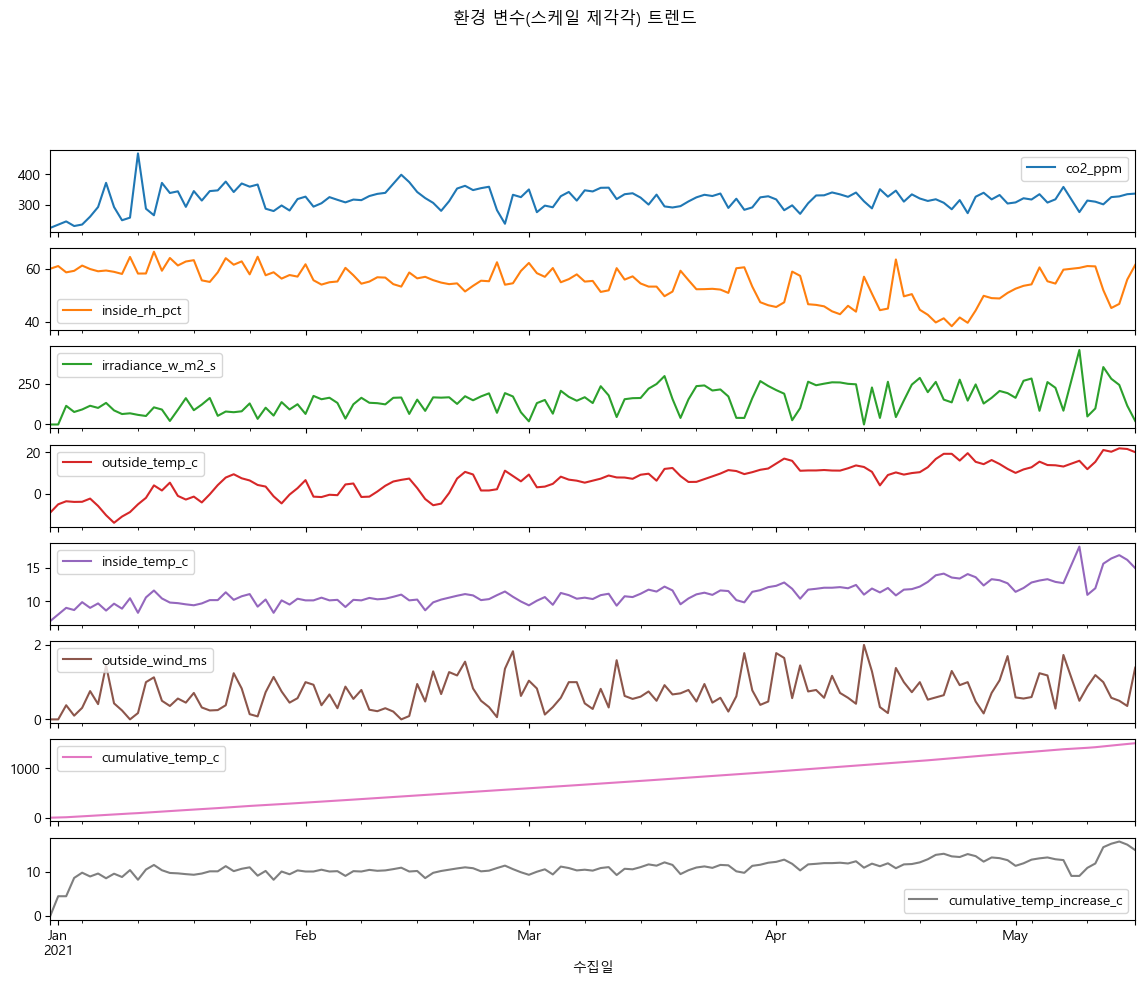

In [200]:
#환경 변수
num_cols = [
   'co2_ppm',                    
    'inside_rh_pct',             
    'irradiance_w_m2_s',          
     'outside_temp_c',             
     'inside_temp_c',             
    'outside_wind_ms',          
         'cumulative_temp_c',          
     'cumulative_temp_increase_c' 
]
e20[num_cols].plot(subplots=True, figsize=(14,10), sharex=True)
plt.suptitle('환경 변수(스케일 제각각) 트렌드', y=1.02)
plt.show()


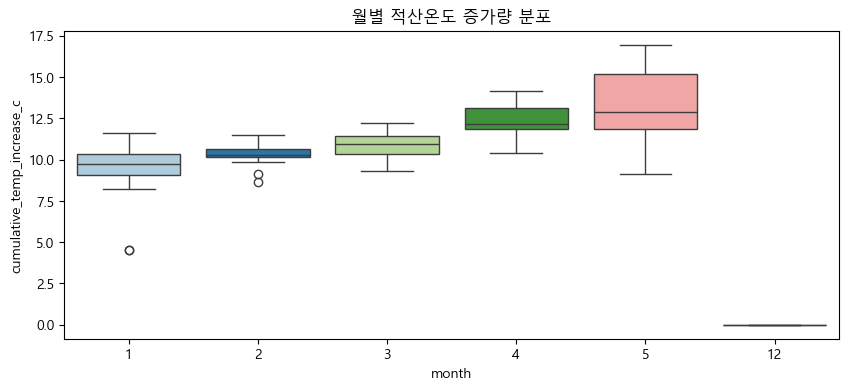

In [203]:
tmp = e20.copy()
tmp['month'] = tmp.index.month
plt.figure(figsize=(10,4))
sns.boxplot(x='month', y='cumulative_temp_increase_c', data=tmp, palette='Paired')
plt.title('월별 적산온도 증가량 분포')
plt.show()

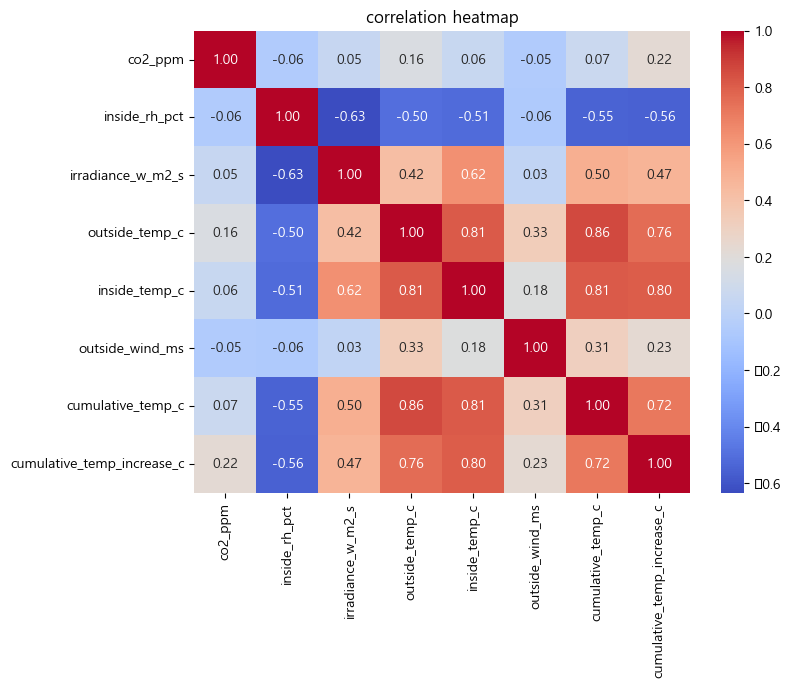

In [204]:
# 상관계수 구하기
corr = e20.corr()

plt.figure(figsize=(8,6))
sns.heatmap(e20[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('correlation heatmap')
plt.show()

In [205]:
df_iqr = e20.copy()
outlier_flags = pd.DataFrame(index=e20.index)

for col in num_cols:
    Q1 = e20[col].quantile(0.25)
    Q3 = e20[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    # True/False 플래그 생성
    outlier_flags[col] = (e20[col] < lower) | (e20[col] > upper)

# 어느 변수에서 하나라도 이상치면 True
df_iqr['is_outlier_iqr'] = outlier_flags.any(axis=1)

# 요약
print(df_iqr['is_outlier_iqr'].value_counts())

is_outlier_iqr
False    119
True      18
Name: count, dtype: int64


In [206]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=100,      # 트리 개수
    contamination=0.01,    # 예상 이상치 비율
    random_state=42
)
# fit → -1: 이상치, +1: 정상
labels = iso.fit_predict(e20[num_cols])

df_if = e20.copy()
df_if['is_outlier_if'] = (labels == -1)

print(df_if['is_outlier_if'].value_counts())

is_outlier_if
False    135
True       2
Name: count, dtype: int64


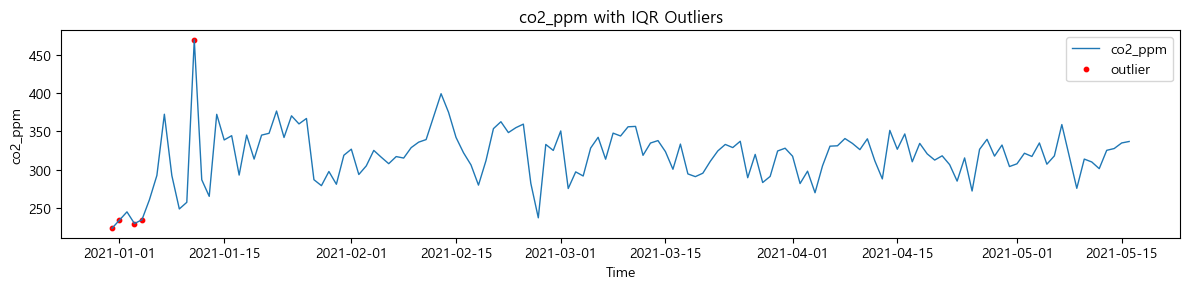

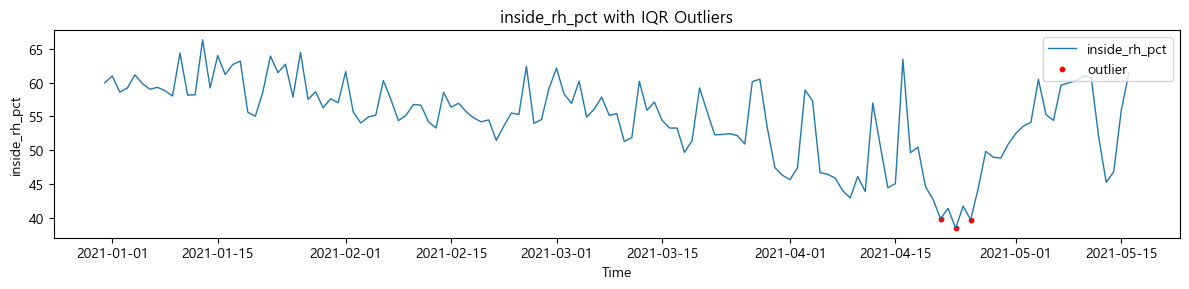

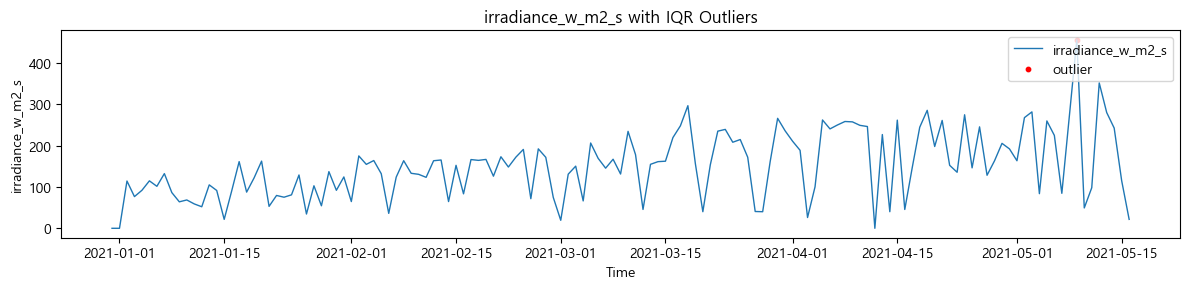

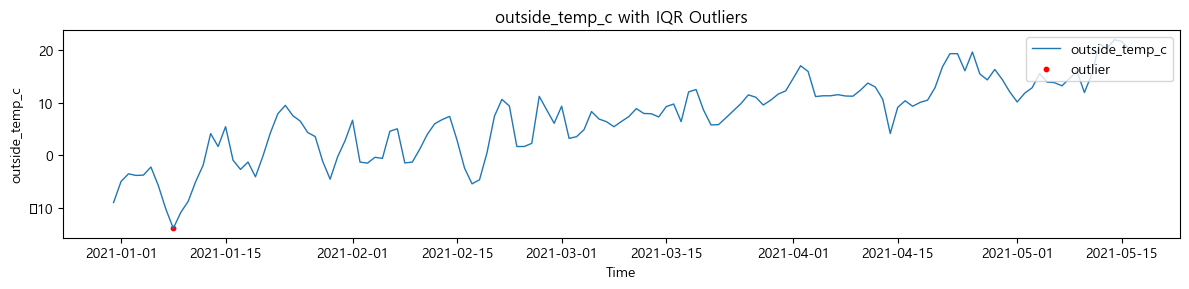

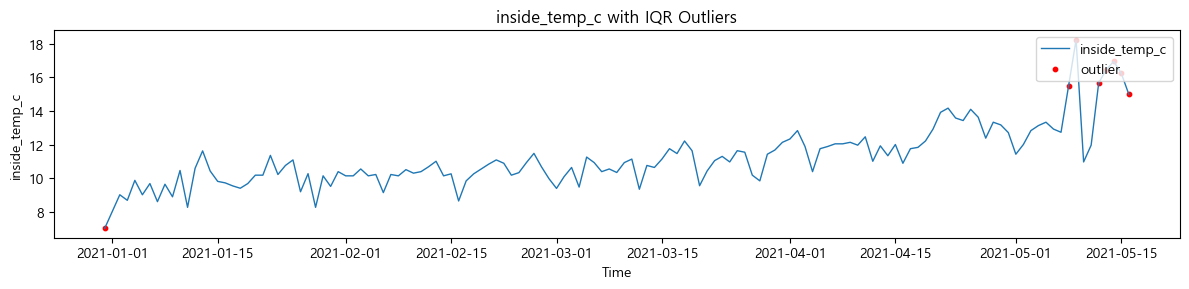

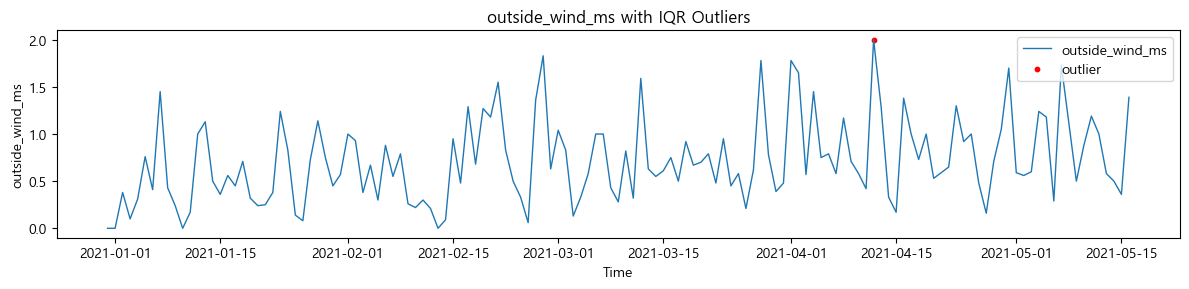

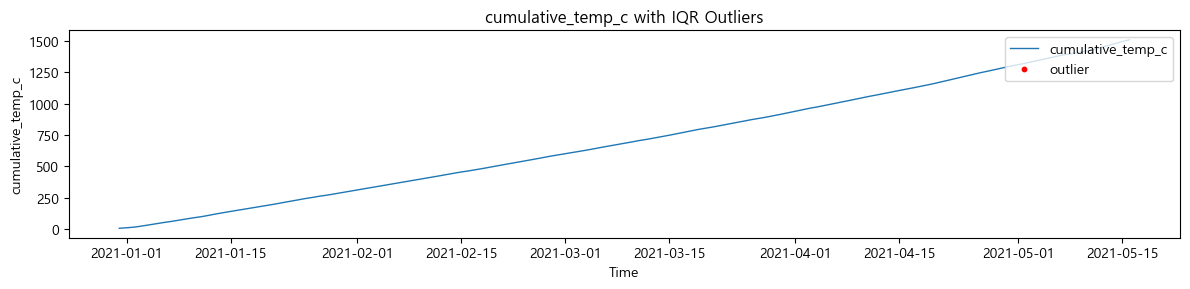

In [207]:
# 2) IQR 계산 및 이상치 플래그 추가
outlier_flags = {}
for col in sensor_cols:
    Q1 = e20[col].quantile(0.25)
    Q3 = e20[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outlier_flags[col] = (e20[col] < lower) | (e20[col] > upper)

# 3) 변수별 시계열 + 이상치 시각화
for col in sensor_cols:
    plt.figure(figsize=(12, 3))
    # 전체 시계열
    plt.plot(e20.index, e20[col], label=f'{col}', linewidth=1)
    # 이상치만 빨간 점으로
    mask = outlier_flags[col]
    plt.scatter(e20.index[mask], e20[col][mask],
                color='red', s=10, label='outlier')
    
    plt.title(f'{col} with IQR Outliers')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

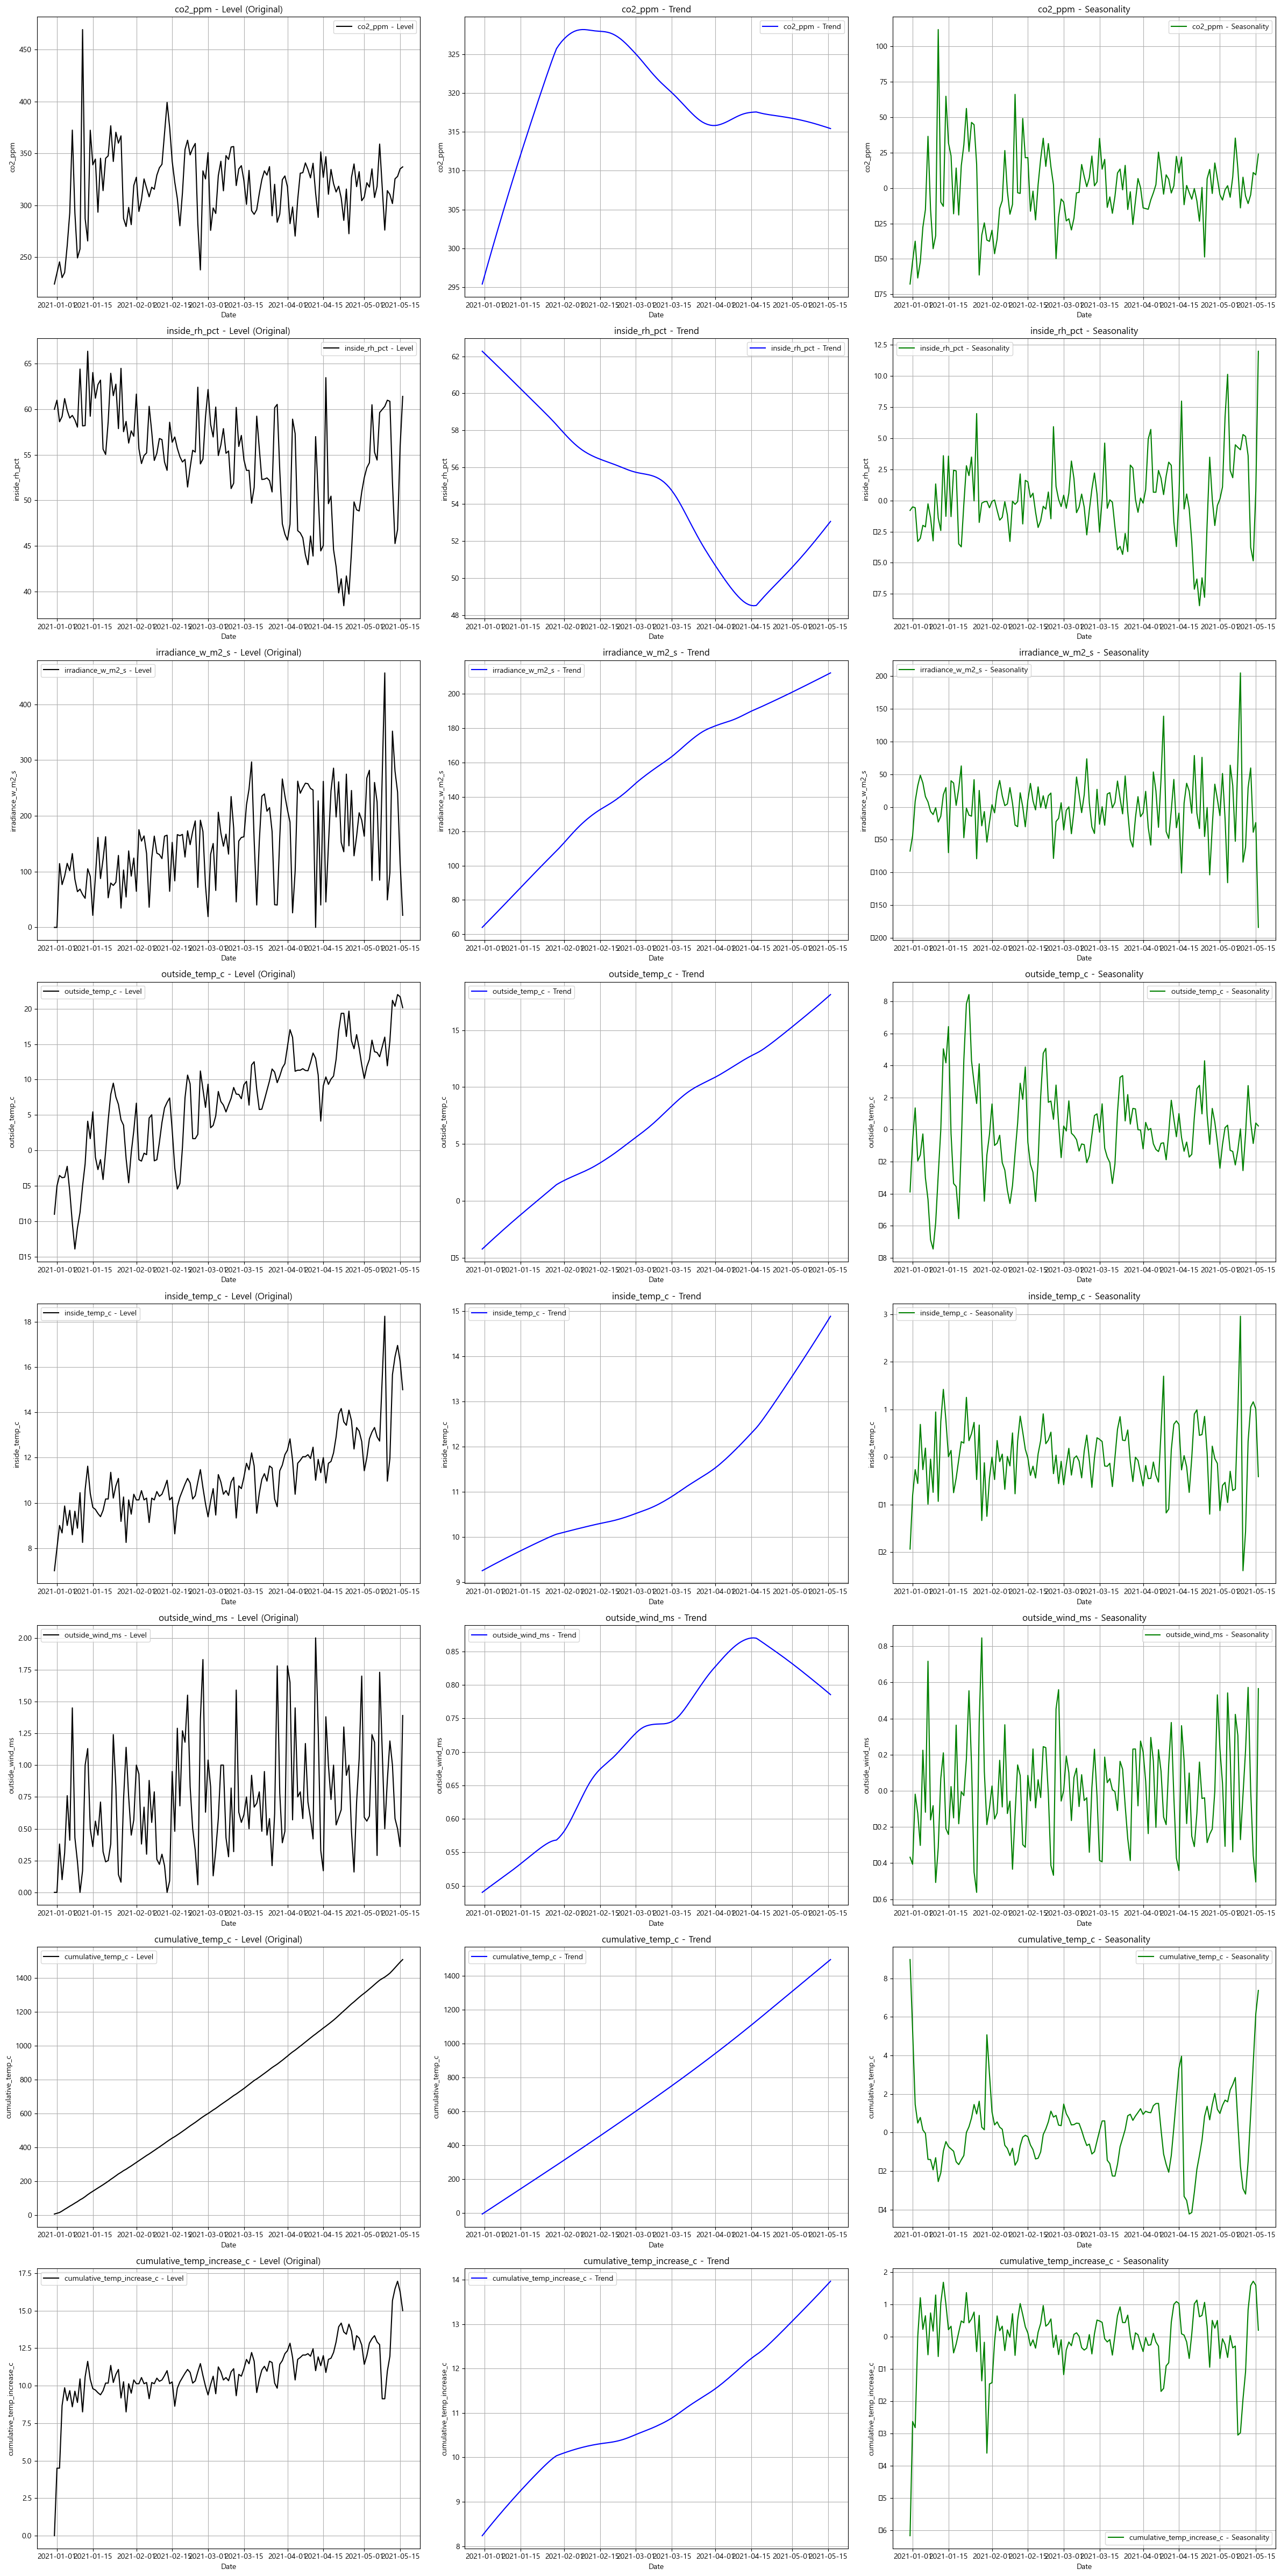

In [209]:
from statsmodels.tsa.seasonal import STL

# 1. datetime 인덱스 설정
e20.index = pd.to_datetime(e20.index)

# 2. 전체 컬럼 리스트
variables = e20.columns.tolist()

# 3. Level, Trend, Seasonality 시각화
plt.figure(figsize=(24, len(variables) * 6))

for i, var in enumerate(variables):
    series = e20[var]
    
    # STL 분해 (대략 30일 주기로 가정)
    stl = STL(series, period=30)
    result = stl.fit()

    level = series  # 원본 데이터
    trend = result.trend
    seasonality = result.seasonal

    # 1. Level (원본)
    plt.subplot(len(variables), 3, 3*i + 1)
    plt.plot(series.index, level, label=f'{var} - Level', color='black')
    plt.title(f'{var} - Level (Original)')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.grid(True)
    plt.legend()

    # 2. Trend
    plt.subplot(len(variables), 3, 3*i + 2)
    plt.plot(series.index, trend, label=f'{var} - Trend', color='blue')
    plt.title(f'{var} - Trend')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.grid(True)
    plt.legend()

    # 3. Seasonality
    plt.subplot(len(variables), 3, 3*i + 3)
    plt.plot(series.index, seasonality, label=f'{var} - Seasonality', color='green')
    plt.title(f'{var} - Seasonality')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## **향후 진행 예정 사항**

- 도메인 지식 습득 후 추가 이상치 탐지 진행
- 시계열 모델들을 적용하고, 데이터셋에 맞는 시계열 모델에 관해 토론 및 선정